## 7.5 批量规范化
这是一种流行且有效的技术，可持续加速深层网络的收敛速度。 再结合在 7.6节中将介绍的残差块，批量规范化使得研究人员能够训练100层以上的网络。

### 7.5.1. 训练深层网络
首先，数据预处理的方式通常会对最终结果产生巨大影响。 回想一下我们应用多层感知机来预测房价的例子（ 4.10节）。 使用真实数据时，我们的第一步是标准化输入特征，使其平均值为0，方差为1。 直观地说，这种标准化可以很好地与我们的优化器配合使用，因为它可以将参数的量级进行统一。<br>
第二，对于典型的多层感知机或卷积神经网络。当我们训练时，中间层中的变量（例如，多层感知机中的仿射变换输出）可能具有更广的变化范围：不论是沿着从输入到输出的层，跨同一层中的单元，或是随着时间的推移，模型参数的随着训练更新变幻莫测。 批量规范化的发明者非正式地假设，这些变量分布中的这种偏移可能会阻碍网络的收敛。 直观地说，我们可能会猜想，如果一个层的可变值是另一层的100倍，这可能需要对学习率进行补偿调整。<br>
第三，更深层的网络很复杂，容易过拟合。 这意味着正则化变得更加重要。<br>
从形式上来说，用$\mathbf{x} \in \mathcal{B}$表示一个来自小批量$\mathcal{B}$
的输入，批量规范化BN根据以下表达式转换<br>
$$
\mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.
$$
在 (7.5.1)中，$\hat{\boldsymbol{\mu}}_\mathcal{B}$是小批量$\mathcal{B}$的样本均值，$\hat{\boldsymbol{\sigma}}_\mathcal{B}$是小批量$\mathcal{B}$的样本标准差。 应用标准化后，生成的小批量的平均值为0和单位方差为1。 由于单位方差（与其他一些魔法数）是一个主观的选择，因此我们通常包含 拉伸参数（scale）$\boldsymbol{\gamma}$和偏移参数（shift）$\boldsymbol{\beta}，它们的形状与$\mathbf{x}$相同。 请注意，$\boldsymbol{\gamma}$和$\boldsymbol{\beta}是需要与其他模型参数一起学习的参数。
$\boldsymbol{\gamma}$和$\boldsymbol{\beta}的计算方式如下：
$$
\hat{\boldsymbol{\mu}}_\mathcal{B} \leftarrow \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x},\\
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 \leftarrow \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B})^2 + \epsilon,
$$

### 7.5.2 批量规范化层

####　7.5.2.1. 全连接层
对于全连接层，我们在全连接层之后、激活函数之前添加批量规范化层。
$$
\mathbf{h} = \phi(\mathrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).
$$

### 7.5.3. 从零实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

c:\Users\yy200\miniconda3\envs\d2l\lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

### 7.5.4. 使用批量规范化层的 LeNet

In [4]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.261, train acc 0.903, test acc 0.798
40931.9 examples/sec on cuda:0


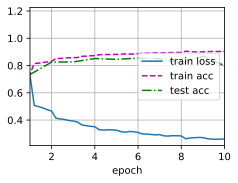

In [5]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [6]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.7465, 1.3019, 2.7897, 2.1920, 4.5836, 3.8175], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([ 1.3976,  1.7674, -2.4625, -0.3512,  2.5452, -3.7808], device='cuda:0',
        grad_fn=<ViewBackward0>))

### 7.5.5. 简明实现

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.273, train acc 0.899, test acc 0.863
81000.4 examples/sec on cuda:0


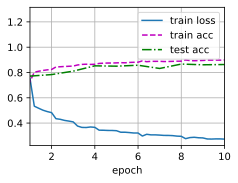

In [8]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

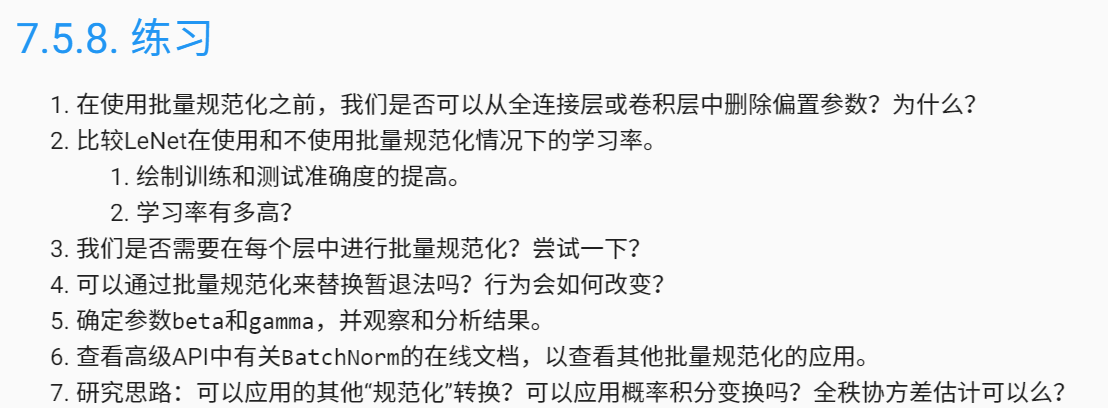

### 7.5.8. 练习解答

#### 1. 在使用批量规范化之前，我们是否可以从全连接层或卷积层中删除偏置参数？为什么？
是的，在使用批量规范化之前可以从全连接层或卷积层中删除偏置参数。因为批量规范化会对输入进行标准化，并且会通过可学习的拉伸参数 $\boldsymbol{\gamma}$ 和偏移参数 $\boldsymbol{\beta}$ 来恢复数据的分布。因此，偏置参数的作用会被批量规范化层取代。

#### 2. 比较LeNet在使用和不使用批量规范化情况下的学习率。
1. **给训练和测试准确度的提高**：批量规范化可以加速收敛并提高模型的泛化能力，因此使用批量规范化的LeNet通常会在训练和测试中表现更好。
2. **学习率有多高**：批量规范化可以缓解梯度消失或爆炸的问题，因此允许使用更高的学习率。

#### 3. 我们是否需要在每个层中进行批量规范化？尝试一下？
不一定需要在每一层中都进行批量规范化。通常在非线性激活函数之前添加批量规范化层即可。可以通过实验观察在不同层添加批量规范化的效果。

#### 4. 可以通过批量规范化来替换暂退法吗？行为会如何改变？
批量规范化和暂退法（Dropout）是两种不同的正则化方法。批量规范化主要通过标准化和可学习参数来稳定训练，而暂退法通过随机丢弃神经元来减少过拟合。两者可以结合使用，但批量规范化在某些情况下可以减少对暂退法的依赖。

#### 5. 确定参数 $\boldsymbol{\beta}$ 和 $\boldsymbol{\gamma}$，并观察和分析结果。
可以通过以下代码查看批量规范化层的 $\boldsymbol{\beta}$ 和 $\boldsymbol{\gamma}$ 参数：
```python
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))
```
这些参数会在训练过程中被优化，以适应数据的分布。

#### 6. 查看高级API有关BatchNorm的在线文档，以查看其他批量规范化的应用。
在PyTorch中，`nn.BatchNorm1d` 和 `nn.BatchNorm2d` 是常用的批量规范化层，分别适用于全连接层和卷积层。可以参考 [PyTorch BatchNorm 文档](https://pytorch.org/docs/stable/nn.html#batchnorm1d) 了解更多细节。

#### 7. 研究思路：可以应用的其他“规范化”转换？可以应用概率积分变换吗？全秩协方差估计可以吗？
除了批量规范化，还可以使用以下规范化方法：
- **层规范化（Layer Normalization）**：对每个样本的所有特征进行标准化。
- **实例规范化（Instance Normalization）**：对每个样本的每个通道进行标准化。
- **组规范化（Group Normalization）**：将通道分组后对每组进行标准化。

概率积分变换可以用于将数据映射到均匀分布，但在深度学习中较少使用。全秩协方差估计可以用于更复杂的分布建模，但计算复杂度较高，通常不适用于深层神经网络。